Rahmanda Afebrio Yuris Soesatyo - 1103223024 / Midterm-Deep Learning

Import Library

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import warnings
warnings.filterwarnings('ignore')

Cek ketersediaan cuda, dikarenakan akan train menggunakan GPU

In [4]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Device count: {torch.cuda.device_count()}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Device name: NVIDIA GeForce RTX 3050 Laptop GPU
Device count: 1


Data preprocessing

In [5]:
train = pd.read_csv(f"midterm_folder/train_transaction.csv")
test = pd.read_csv(f"midterm_folder/test_transaction.csv")

In [6]:
print("CLASS DISTRIBUTION")

print(f"\nOriginal Training Data:")
print(train['isFraud'].value_counts())
print(f"\nClass Ratio:")
fraud_ratio = train['isFraud'].value_counts(normalize=True)
print(fraud_ratio)
print(f"\nFraud Rate: {fraud_ratio[1]:.4%}")

class_weights = compute_class_weight('balanced', 
                                      classes=np.unique(train['isFraud']), 
                                      y=train['isFraud'])
print(f"\nClass Weights: {dict(zip([0, 1], class_weights))}")
print("="*60)

CLASS DISTRIBUTION

Original Training Data:
isFraud
0    569877
1     20663
Name: count, dtype: int64

Class Ratio:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

Fraud Rate: 3.4990%

Class Weights: {0: np.float64(0.5181293507195412), 1: np.float64(14.289793350433142)}


In [7]:
def engineer_features(df, is_train=True):

    df = df.copy()
    
    # 1. Log1p transforms for amount-related features
    amount_cols = [col for col in df.columns if 'amount' in col.lower() or 'TransactionAmt' in col]
    for col in amount_cols:
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            df[f'{col}_log1p'] = np.log1p(df[col].fillna(0))
    
    # 2. Time-based features (if TimeDelta exists)
    if 'TransactionDT' in df.columns:
        df['TransactionDT_hour'] = (df['TransactionDT'] / 3600) % 24
        df['TransactionDT_day'] = (df['TransactionDT'] / 86400) % 7
        df['TransactionDT_week'] = (df['TransactionDT'] / 604800)
        
    # 3. Interaction features
    if 'TransactionAmt' in df.columns:
        # Card transaction patterns
        if 'card1' in df.columns:
            df['amt_card1_ratio'] = df['TransactionAmt'] / (df.groupby('card1')['TransactionAmt'].transform('mean') + 1)
        if 'card2' in df.columns:
            df['amt_card2_ratio'] = df['TransactionAmt'] / (df.groupby('card2')['TransactionAmt'].transform('mean') + 1)
        
        # Amount bins
        df['amt_bin'] = pd.cut(df['TransactionAmt'], bins=10, labels=False)
    
    # 4. Card aggregation features
    card_cols = [col for col in df.columns if 'card' in col.lower()]
    for col in card_cols[:4]:  # Limit to first 4 card columns
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            df[f'{col}_count'] = df.groupby(col)[col].transform('count')
    
    # 5. Missing value indicators
    df['missing_count'] = df.isnull().sum(axis=1)
    
    # 6. Email domain features (if exists)
    email_cols = [col for col in df.columns if 'email' in col.lower()]
    for col in email_cols:
        if col in df.columns:
            df[f'{col}_nan'] = df[col].isnull().astype(int)
    
    # 7. Device info features
    if 'DeviceInfo' in df.columns:
        df['DeviceInfo_nan'] = df['DeviceInfo'].isnull().astype(int)
    
    return df

print("Engineering features for train and test sets...")
train_fe = engineer_features(train, is_train=True)
test_fe = engineer_features(test, is_train=False)
print(f"Original features: {train.shape[1]}")
print(f"After feature engineering: {train_fe.shape[1]}")
print(f"New features added: {train_fe.shape[1] - train.shape[1]}")

Engineering features for train and test sets...
Original features: 394
After feature engineering: 407
New features added: 13


Diperlukan aggresive feature reduction dikarenakan keterbatasan RAM pada device

In [8]:
import gc
import numpy as np
import pandas as pd

# Clear everything first
gc.collect()

print("Initial shapes:")
print(f"Train: {train_fe.shape}")
print(f"Test: {test_fe.shape}")

# STEP 1: REMOVE FEATURES IMMEDIATELY - before any processing
print("\n=== AGGRESSIVE FEATURE REDUCTION ===")

# Remove constant columns (zero variance)
print("Removing constant columns...")
nunique = train_fe.nunique()
cols_to_keep = nunique[nunique > 1].index.tolist()
if 'isFraud' not in cols_to_keep:
    cols_to_keep.append('isFraud')

train_fe = train_fe[cols_to_keep]
test_fe = test_fe[[col for col in cols_to_keep if col != 'isFraud']]
gc.collect()

print(f"After removing constants: {train_fe.shape[1]} columns")

# Remove columns with >90% missing values
print("Removing sparse columns...")
missing_pct = train_fe.isnull().sum() / len(train_fe)
cols_to_keep = missing_pct[missing_pct < 0.9].index.tolist()
if 'isFraud' not in cols_to_keep:
    cols_to_keep.append('isFraud')

train_fe = train_fe[cols_to_keep]
test_fe = test_fe[[col for col in cols_to_keep if col != 'isFraud']]
gc.collect()

print(f"After removing sparse columns: {train_fe.shape[1]} columns")

# STEP 2: Encode categoricals efficiently
y_full = train_fe['isFraud'].values
feature_cols = [col for col in train_fe.columns if col != 'isFraud']

cat_cols = train_fe[feature_cols].select_dtypes(include=['object']).columns.tolist()
print(f"\nEncoding {len(cat_cols)} categorical columns...")

from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    le = LabelEncoder()
    # Combine and fit
    combined = pd.concat([train_fe[col].astype(str), test_fe[col].astype(str)])
    le.fit(combined)
    
    # Transform directly to numpy then assign
    train_encoded = le.transform(train_fe[col].astype(str))
    test_encoded = le.transform(test_fe[col].astype(str))
    
    train_fe[col] = train_encoded
    test_fe[col] = test_encoded
    
    del combined, le, train_encoded, test_encoded
    gc.collect()

# STEP 3: Extract as numpy arrays immediately
print("\nExtracting to numpy arrays...")
X_full = train_fe[feature_cols].values.astype(np.float32)
X_test_final = test_fe[feature_cols].values.astype(np.float32)

# DELETE dataframes NOW
del train_fe, test_fe, feature_cols, cat_cols
gc.collect()

print(f"\nArray shapes:")
print(f"X_full: {X_full.shape}")
print(f"Memory: {X_full.nbytes / 1024**2:.1f} MB")

# STEP 4: Fill NaN efficiently
print("Filling NaN...")
col_medians = np.nanmedian(X_full, axis=0)
for i in range(X_full.shape[1]):
    mask = np.isnan(X_full[:, i])
    if mask.any():
        X_full[mask, i] = col_medians[i]
    
    mask_test = np.isnan(X_test_final[:, i])
    if mask_test.any():
        X_test_final[mask_test, i] = col_medians[i]

del col_medians
gc.collect()

# STEP 5: Variance-based feature selection
print("Variance filtering...")
variances = np.var(X_full, axis=0)
threshold = np.percentile(variances, 25)  # Keep top 75% by variance
high_var_mask = variances > threshold

X_full = X_full[:, high_var_mask]
X_test_final = X_test_final[:, high_var_mask]
del variances, high_var_mask
gc.collect()

print(f"After variance filter: {X_full.shape[1]} features")

# STEP 6: Split data
print("\nSplitting data...")
from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

del X_full, y_full
gc.collect()

print(f"Train: {X_train_full.shape}")
print(f"Valid: {X_valid_full.shape}")

# STEP 7: SMOTE (if you still have memory)
print("\nApplying SMOTE...")
from imblearn.over_sampling import SMOTE

try:
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_full, y_train_full)
    print(f"After SMOTE: {X_train_balanced.shape}")
except MemoryError:
    print("SMOTE failed - using original imbalanced data")
    X_train_balanced = X_train_full
    y_train_balanced = y_train_full

del X_train_full, y_train_full
gc.collect()

# STEP 8: Scale
print("\nScaling...")
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_valid_scaled = scaler.transform(X_valid_full)
X_test_scaled = scaler.transform(X_test_final)

print("\n✅ DONE!")
print(f"Final train shape: {X_train_scaled.shape}")

Initial shapes:
Train: (590540, 407)
Test: (506691, 406)

=== AGGRESSIVE FEATURE REDUCTION ===
Removing constant columns...
After removing constants: 407 columns
Removing sparse columns...
After removing sparse columns: 405 columns

Encoding 14 categorical columns...

Extracting to numpy arrays...

Array shapes:
X_full: (590540, 404)
Memory: 910.1 MB
Filling NaN...
Variance filtering...
After variance filter: 303 features

Splitting data...
Train: (472432, 303)
Valid: (118108, 303)

Applying SMOTE...
After SMOTE: (911804, 303)

Scaling...

✅ DONE!
Final train shape: (911804, 303)


Building Neural network architecture (MLP)

In [9]:
from torch import nn


class ImprovedFraudMLP(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedFraudMLP, self).__init__()
        
        # Layer 1
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        
        # Layer 2
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        # Layer 3
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)
        
        # Output layer
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        # Output
        x = self.fc4(x)
        x = torch.sigmoid(x)
        
        return x

print("MLP Architecture:")
print("="*60)
model_nn = ImprovedFraudMLP(input_dim=X_train_scaled.shape[1])
print(model_nn)
print("="*60)
print(f"Total parameters: {sum(p.numel() for p in model_nn.parameters())}")

MLP Architecture:
ImprovedFraudMLP(
  (fc1): Linear(in_features=303, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 119937


Training MLP

In [10]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

class ImprovedEarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, score, model):
        if self.best_score is None or score > self.best_score + self.min_delta:
            self.best_score = score
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_pytorch_model(X_train, y_train, X_valid, y_valid, n_epochs=50):
    """Train PyTorch MLP with all improvements"""
    
    # Convert to numpy if needed
    if hasattr(y_train, 'values'):
        y_train = y_train.values
    if hasattr(y_valid, 'values'):
        y_valid = y_valid.values
    
    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).view(-1, 1)
    
    # Create data loaders
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)
    
    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ImprovedFraudMLP(input_dim=X_train.shape[1]).to(device)
    
    # Loss and optimizer (AdamW with weight decay)
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
    
    # Early stopping
    early_stopper = ImprovedEarlyStopping(patience=5, min_delta=0.0001)
    
    print(f"\nTraining on device: {device}")
    print("="*60)
    
    best_auc = 0
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        total_loss = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_valid_tensor.to(device)).detach().cpu().numpy()
            auc = roc_auc_score(y_valid, val_preds)
        
        # Learning rate step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        if auc > best_auc:
            best_auc = auc
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | "
                  f"Valid AUC: {auc:.6f} | LR: {current_lr:.6f}")
        
        # Early stopping check
        early_stopper(auc, model)
        if early_stopper.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation AUC: {early_stopper.best_score:.6f}")
            # Restore best model
            model.load_state_dict(early_stopper.best_state)
            break
    
    print(f"Training completed! Best AUC: {best_auc:.6f}")
    
    return model, best_auc

model_nn, nn_auc = train_pytorch_model(
    X_train_scaled, y_train_balanced, 
    X_valid_scaled, y_valid_full,
    n_epochs=50
)


Training on device: cuda
Epoch   1/50 | Loss: 136.6730 | Valid AUC: 0.899329 | LR: 0.000999
Epoch   5/50 | Loss: 72.4891 | Valid AUC: 0.919418 | LR: 0.000976
Epoch  10/50 | Loss: 58.4536 | Valid AUC: 0.927266 | LR: 0.000905
Epoch  15/50 | Loss: 51.9553 | Valid AUC: 0.929965 | LR: 0.000794
Epoch  20/50 | Loss: 47.0350 | Valid AUC: 0.930072 | LR: 0.000655

Early stopping triggered at epoch 24
Best validation AUC: 0.933618
Training completed! Best AUC: 0.933618


Save hasil prediksi

In [11]:
print("\nGenerating test predictions with best model...")

use_nn = True

if use_nn:
    # PyTorch MLP predictions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_nn.eval()
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    with torch.no_grad():
        test_pred = model_nn(X_test_tensor.to(device)).detach().cpu().numpy().flatten()
    
    # Save PyTorch model
    torch.save(model_nn.state_dict(), 'best_fraud_model_pytorch.pth')
    print(f"PyTorch model saved as 'best_fraud_model_pytorch.pth'")

    submission = pd.DataFrame({
    "TransactionID": test["TransactionID"],
    "isFraud": test_pred
})


print(f"\nPredictions saved to 'submission_improved.csv'")
print("\nPrediction statistics:")
print(f"  Mean:   {test_pred.mean():.6f}")
print(f"  Median: {np.median(test_pred):.6f}")
print(f"  Min:    {test_pred.min():.6f}")
print(f"  Max:    {test_pred.max():.6f}")
print(f"  Std:    {test_pred.std():.6f}")


Generating test predictions with best model...
PyTorch model saved as 'best_fraud_model_pytorch.pth'

Predictions saved to 'submission_improved.csv'

Prediction statistics:
  Mean:   0.060030
  Median: 0.008307
  Min:    0.000000
  Max:    1.000000
  Std:    0.163962


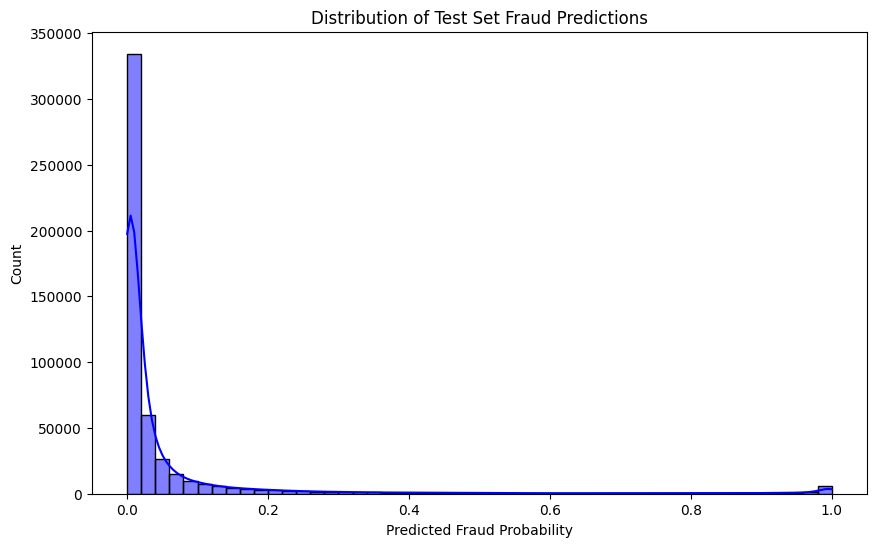

In [12]:
#visualisasi hasil
plt.figure(figsize=(10, 6))
sns.histplot(test_pred, bins=50, kde=True, color='blue')
plt.title('Distribution of Test Set Fraud Predictions')
plt.xlabel('Predicted Fraud Probability')
plt.show()